# Machine Learning Demo on NLSY Data

First, import the relevant files and set up the cohort dataframes...

In [1]:
import nlsy
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import brier_score_loss

%matplotlib inline

NLSY_db = nlsy.NLSY_database("data.db")
(cohort_79, cohort_97) = NLSY_db.cohorts
data_79 = cohort_79.data(impute_values=True)
data_97 = cohort_97.data(impute_values=True)

Then, ensure that each cohort's dataframe includes the same columns. (This is necessary because some industry/occupation codes are used within only one of the two cohorts.)

In [2]:
for col in data_79.columns:
    if not col in data_97.columns:
        data_97[col] = 0
        
for col in data_97.columns:
    if not col in data_79.columns:
        data_79[col] = 0

Next, create the merged data incorporating the samples from both cohorts, define the predictor variables (in this case, we're using everything *except* case_id and sample_id, which are housekeeping variables, and the year, which is not relevant to predictions about future income shock risk), and create "test" and "train" samples.

For the purpose of this example, our training set consists of 80% of the instances across *both* cohorts. We can, of course, experiment with training models only on one cohort and then using each to predict the other.

In [3]:
merged_data = pd.concat([data_79, data_97], sort=False)
merged_data.drop(merged_data[merged_data["adjusted_income"] <= 1000].index, inplace=True)
merged_data.fillna(0, inplace=True)

predictors = list(merged_data.columns)
vars_to_drop = ["case_id", "sample_id", "year", "shock", "region", "highest_grade", "industry", "occupation"]
for var in vars_to_drop:
    predictors.remove(var)
    
X_train, X_test, y_train, y_test = train_test_split(merged_data[predictors], merged_data["shock"], test_size = 0.2)

Because we're dealing with an imbalanced class (only ~20% of people suffer an income shock in a given year), F1 score is a relatively poor way of evaluating the model. Even a naive prediction that no one ever suffers an income shock would be right 80% of the time!

To better measure the skill of our model, then, it's important to establish a baseline. The below code provides a classification report for a "dummy" predictor that presumes no one ever has an income shock, as well as a [Brier skill reference](https://www.statisticshowto.datasciencecentral.com/brier-score/) for a "dummy" predictor that assigns everyone an *equal* chance of an income shock (that is, the ~20% average risk seen in the data).

In [5]:
dummy_predictions = np.full((len(X_test), 1), merged_data["shock"].median())
dummy_probs = np.full((len(X_test), 1), merged_data["shock"].mean())
dummy_report = classification_report(y_test, dummy_predictions, target_names=["No shock","Shock"])
print(dummy_report)

brier_skill_ref = brier_score_loss(y_test, dummy_probs)
print("The Brier score of the dummy predictor is {:.03f}.".format(brier_skill_ref))

              precision    recall  f1-score   support

    No shock       0.76      1.00      0.87     28163
       Shock       0.00      0.00      0.00      8787

   micro avg       0.76      0.76      0.76     36950
   macro avg       0.38      0.50      0.43     36950
weighted avg       0.58      0.76      0.66     36950

The Brier score of the dummy predictor is 0.181.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


With all of that prep work completed, we can now deploy a real machine learning model on the data set -- in this case, a gradient boosting classifier.

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(n_estimators=100, learning_rate=.3, min_samples_leaf=25, max_depth=4)#, max_features=40)
gbrt.fit(X_train, y_train)

gbrt_report = classification_report(y_test, gbrt.predict(X_test), target_names=["No shock","Shock"])
print(gbrt_report)

y_predictions = gbrt.predict_proba(X_test)[:,1]
gbrt_score = brier_score_loss(y_test, y_predictions)
gbrt_skill = (1 - (gbrt_score / brier_skill_ref))

print("The Brier score of the Gradient Boosting Classifier is {:.03f}, translating to a Brier skill score of {:.03f}.".format(gbrt_score, gbrt_skill))

              precision    recall  f1-score   support

    No shock       0.78      0.97      0.87     28163
       Shock       0.59      0.13      0.21      8787

   micro avg       0.77      0.77      0.77     36950
   macro avg       0.69      0.55      0.54     36950
weighted avg       0.74      0.77      0.71     36950

The Brier score of the Gradient Boosting Classifier is 0.163, translating to a Brier skill score of 0.099.


The model shows small but significant improvement in prediction skills, as measured both by F1 score and Brier score.

Better yet, we can see that our predictions are fairly well-calibrated. That is, out of the people whom our model assigns a (say) 40% chance of an income shock, roughly 40% really do suffer an income shock (although the model breaks a bit at high probability levels). That's demonstrated by the below calibration curve:

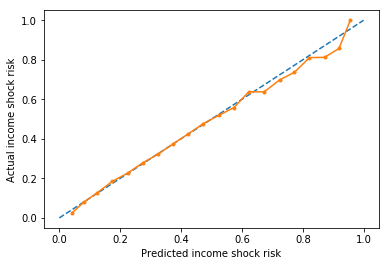

In [7]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
logreg_x, logreg_y = calibration_curve(y_test, y_predictions, n_bins=20)

# Plot a reference line showing what a perfectly calibrated model would look like.
plt.plot([0, 1], [0, 1], linestyle='--')

# Plot the model's actual reliability.
plt.plot(logreg_y, logreg_x, marker='.')

plt.ylabel('Actual income shock risk')
plt.xlabel('Predicted income shock risk')
plt.show()

Of course, it's possible that a model can be well-calibrated and still meaningless! Our "dummy" predictor that assigned everyone a ~20% chance of an income shock was, technically, perfectly calibrated, since everyone in aggregate *really did* experience a ~20% risk.

So to determine whether the model is assigning meaningfully different risk levels to different individuals, let's plot a histogram showing how many people received a given risk score:

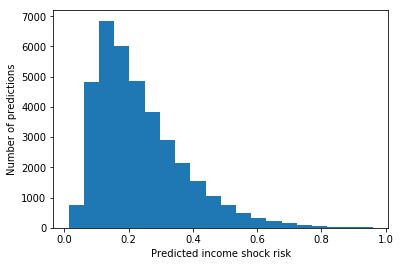

In [8]:
plt.hist(y_predictions, bins=20)
plt.ylabel('Number of predictions');
plt.xlabel('Predicted income shock risk')
plt.show()

We can also determine which variables are most significant in our predictions:

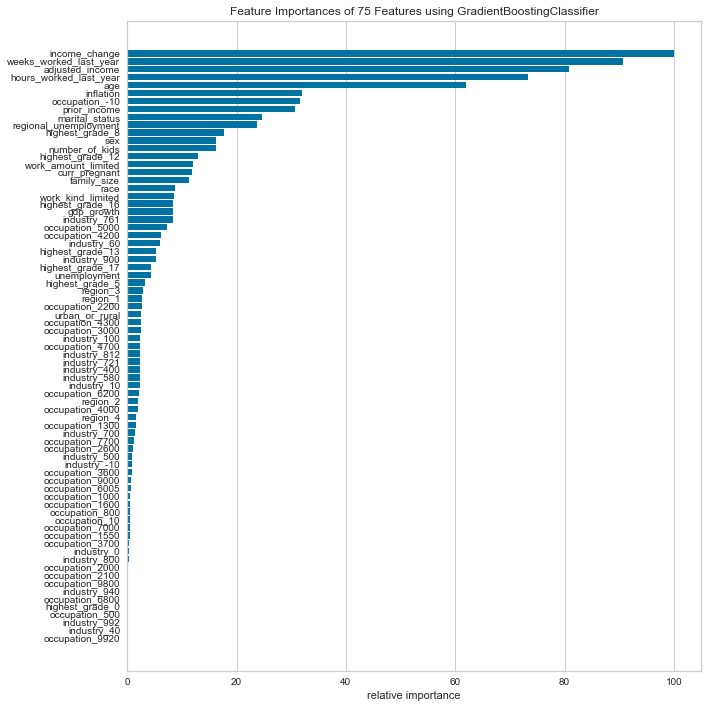

In [9]:
from yellowbrick.features.importances import FeatureImportances

# Create a new matplotlib figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(figsize=(10,10))

viz = FeatureImportances(gbrt, ax=ax)
viz.fit(X_test, y_test)
viz.poof()